# Verification Steps for Autonomous Mode

This notebook will be used to test and debug the .py files for the Search and Sample assignment.

---
## Verify Perception.py
### Prep the test code

In [1]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
import perception
from drive_rover import RoverState

# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: you need to convert this to radians
    # before adding to pixel_angles
rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20
rover_worldmap = np.zeros((200, 200, 3)).astype(np.float)
rover_ground_truth = mpimg.imread('../calibration_images/map_bw.png')
rover_ground_truth_3d = np.dstack((rover_ground_truth*0, rover_ground_truth*255, rover_ground_truth*0)).astype(np.float)

print("World Map Dimenstions: {}".format(rover_worldmap.shape))
print("Rover Dimenstions: X:{}, Y:{}, Yaw:{}".format(rover_xpos, rover_ypos, rover_yaw))

Rover = RoverState()
Rover.pos = (rover_xpos, rover_ypos)
Rover.yaw = rover_yaw
Rover.ground_truth = rover_ground_truth_3d
Rover.worldmap = rover_worldmap
Rover.pitch = 0.0
Rover.roll = 0.0

FakeRover = RoverState()
FakeRover.pos = (rover_xpos, rover_ypos)
FakeRover.yaw = rover_yaw
FakeRover.ground_truth = rover_ground_truth_3d
FakeRover.worldmap = rover_worldmap
FakeRover.pitch = 0.0
FakeRover.roll = 0.0

World Map Dimenstions: (200, 200, 3)
Rover Dimenstions: X:[25.36359056], Y:[28.89744572], Yaw:[249.4629329]


### Analysis Steps Test Functions


In [2]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(Fake_Rover, source, destination):
    #plot the test images
    fig = plt.figure(figsize=(12,9))
    plt.subplot(431)
    plt.tight_layout()
    plt.title("Original Image")
    plt.imshow(Fake_Rover.img, cmap='gray')
  
    # 2) Apply perspective transform
    warped = perception.perspect_transform(Fake_Rover.img, source, destination) 
    plt.subplot(432)
    plt.tight_layout()
    plt.title("Warped Image")
    plt.imshow(warped, cmap='gray')
    
    # 0 is obstacle data (Red)
    # 1 is rock sample data (Green)
    # 3 is navigatable terrain data (Blue)
    color_max_thresh = [(160, 160, 160), (200, 200, 75), (255, 255, 255)]
    color_min_thresh = [(0, 0, 0), (125, 100, 0), (160, 160, 160)]
    image_title = ["Obstacle", "Rock Sample", "Terrain"]
    for item_type in range(0, 3): 

        # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
        threshed = perception.color_thresh(warped, color_min_thresh[item_type], color_max_thresh[item_type])
        plt.subplot(434+item_type)
        plt.tight_layout()
        plt.title(image_title[item_type]+" Mask")
        plt.imshow(threshed, cmap='gray')

        # 4) Convert thresholded image pixel values to rover-centric coords
        xpix, ypix = perception.rover_coords(threshed)
        dist, angles = perception.to_polar_coords(xpix, ypix)
        
        plt.subplot(437+item_type)
        plt.tight_layout()
        plt.plot(xpix, ypix, '.')
        plt.ylim(-160, 160)
        plt.xlim(0, 160)        
        arrow_length = 100
        mean_dir = np.mean(angles)
        x_arrow = arrow_length * np.cos(mean_dir)
        y_arrow = arrow_length * np.sin(mean_dir)
        plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
        plt.title(image_title[item_type]+" in Rover Coordinates")

        # 5) Convert rover-centric pixel values to world coords
        scale = 10
        x_world, y_world = perception.pix_to_world(xpix, ypix,
                                        rover_xpos, rover_ypos,
                                        rover_yaw, Fake_Rover.worldmap.shape[0], scale)
        
        world_dist, world_angles = perception.to_polar_coords(x_world, y_world)
        
        arrow_length = 100
        world_mean_dir = np.mean(angles)
        world_x_arrow = arrow_length * np.cos(world_mean_dir)
        world_y_arrow = arrow_length * np.sin(world_mean_dir)
        plt.subplot(4,3,10+item_type)
        plt.tight_layout()
        plt.plot(x_world, y_world, '.')
        plt.plot(rover_xpos, rover_ypos, 'go')
        plt.arrow(rover_xpos[0], rover_ypos[0], world_x_arrow, world_y_arrow, color='red', zorder=2, head_width=10, width=2)
        plt.ylim(0, 200)
        plt.xlim(0, 200)
        plt.title(image_title[item_type]+" in Rover Coordinates")
        
#Generate a map overlay
def generate_overlay(Fake_Rover, source, destination):
    # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((Fake_Rover.img.shape[0] + Fake_Rover.worldmap.shape[0], Fake_Rover.img.shape[1]*2, 3))
    # Next you can populate regions of the image with various output
    # Here I'm putting the original image in the upper left hand corner
    output_image[0:Fake_Rover.img.shape[0], 0:Fake_Rover.img.shape[1]] = Fake_Rover.img

    # Let's create more images to add to the mosaic, first a warped image
    warped = perception.perspect_transform(Fake_Rover.img, source, destination)
    # Add the warped image in the upper right hand corner
    output_image[0:Fake_Rover.img.shape[0], Fake_Rover.img.shape[1]:] = warped

    # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(Fake_Rover.worldmap, 1, Fake_Rover.ground_truth, 0.5, 0)
    # Flip map overlay so y-axis points upward and add to output_image 
    output_image[Fake_Rover.img.shape[0]:, 0:Fake_Rover.worldmap.shape[1]] = np.flipud(map_add)
    
    return output_image

### Verify Using a Rock Calibration Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


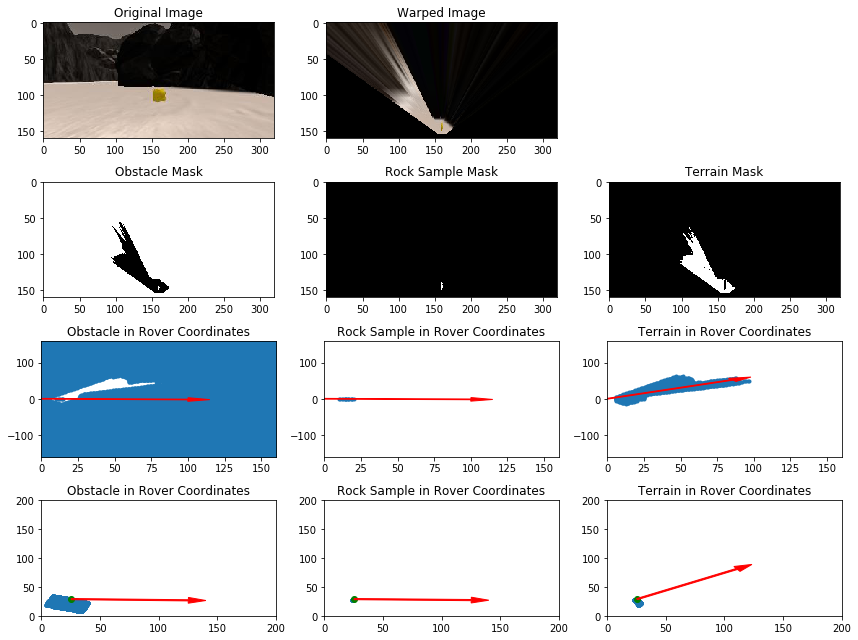

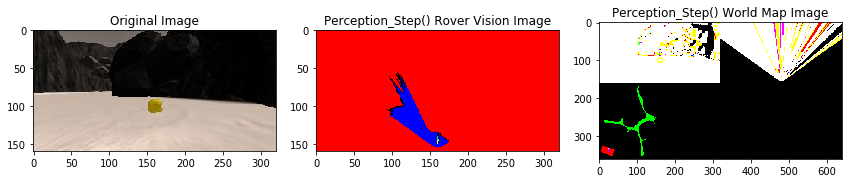

In [3]:
from PIL import Image

example_rock = '../calibration_images/example_rock1.jpg'
image_rock = mpimg.imread(example_rock)

####### Verify the independent analysis steps #######
rover_dst_size = 5 
rover_bottom_offset = 6
image_rock_source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
image_rock_destination = np.float32([[image_rock.shape[1]/2 - rover_dst_size, image_rock.shape[0] - rover_bottom_offset],
              [image_rock.shape[1]/2 + rover_dst_size, image_rock.shape[0] - rover_bottom_offset],
              [image_rock.shape[1]/2 + rover_dst_size, image_rock.shape[0] - 2*rover_dst_size - rover_bottom_offset], 
              [image_rock.shape[1]/2 - rover_dst_size, image_rock.shape[0] - 2*rover_dst_size - rover_bottom_offset],
              ]) 
FakeRover.img = image_rock
process_image(FakeRover, image_rock_source, image_rock_destination)

####### Verify the perception step for the autonomous mode #######
Rover.img = image_rock
perception.perception_step(Rover)
output_img = generate_overlay(Rover, image_rock_source, image_rock_destination)

fig = plt.figure(figsize=(12,9))
plt.subplot(1,3,1)
plt.tight_layout()
plt.title("Original Image")
plt.imshow(Rover.img, cmap='gray')

plt.subplot(1,3,2)
plt.tight_layout()
plt.title("Perception_Step() Rover Vision Image")
plt.imshow(Rover.vision_image, cmap='gray')

plt.subplot(1,3,3)
plt.tight_layout()
plt.title("Perception_Step() World Map Image")
plt.imshow(output_img, cmap='gray')

### Verify Using a Random Image from the Test Dataset

F:\Anaconda3\envs\RoboND\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\Anaconda3\envs\RoboND\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


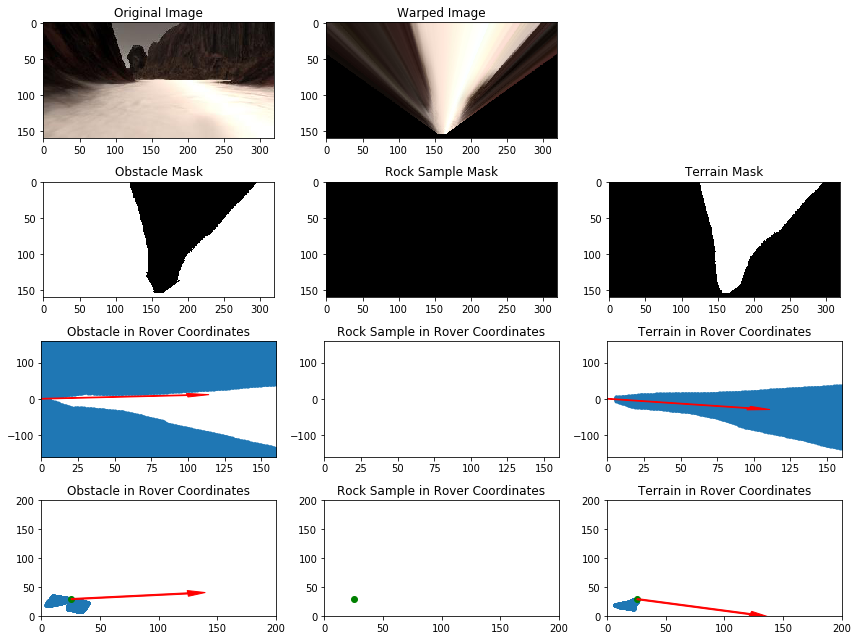

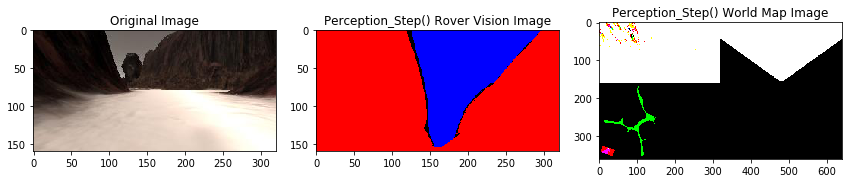

In [4]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])

####### Verify the independent analysis steps #######
rover_dst_size = 5 
rover_bottom_offset = 6
image_source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
image_destination = np.float32([[image_rock.shape[1]/2 - rover_dst_size, image_rock.shape[0] - rover_bottom_offset],
              [image_rock.shape[1]/2 + rover_dst_size, image_rock.shape[0] - rover_bottom_offset],
              [image_rock.shape[1]/2 + rover_dst_size, image_rock.shape[0] - 2*rover_dst_size - rover_bottom_offset], 
              [image_rock.shape[1]/2 - rover_dst_size, image_rock.shape[0] - 2*rover_dst_size - rover_bottom_offset],
              ]) 
FakeRover.img = image
process_image(FakeRover, image_source, image_destination)

####### Verify the perception step for the autonomous mode #######
Rover.img = image
perception.perception_step(Rover)
output_img = generate_overlay(Rover, image_source, image_destination)

fig = plt.figure(figsize=(12,9))
plt.subplot(1,3,1)
plt.tight_layout()
plt.title("Original Image")
plt.imshow(Rover.img, cmap='gray')

plt.subplot(1,3,2)
plt.tight_layout()
plt.title("Perception_Step() Rover Vision Image")
plt.imshow(Rover.vision_image, cmap='gray')

plt.subplot(1,3,3)
plt.tight_layout()
plt.title("Perception_Step() World Map Image")
plt.imshow(output_img, cmap='gray')

### Test Pitch and Yaw Thresholds

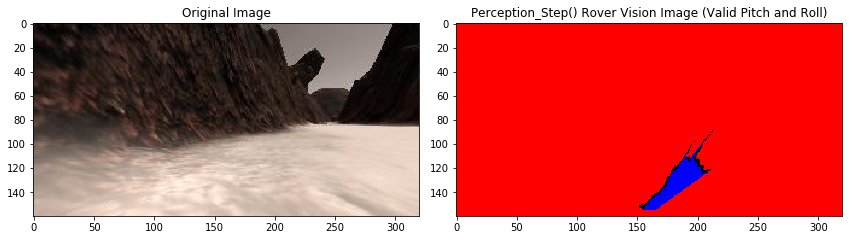

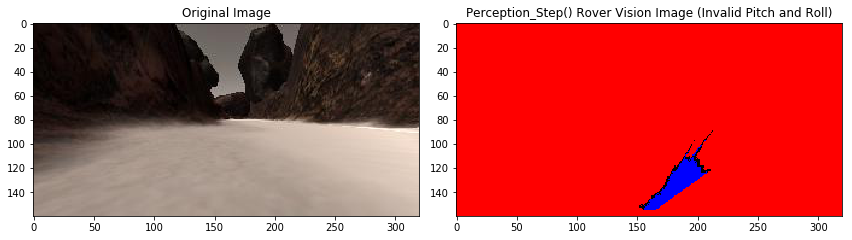

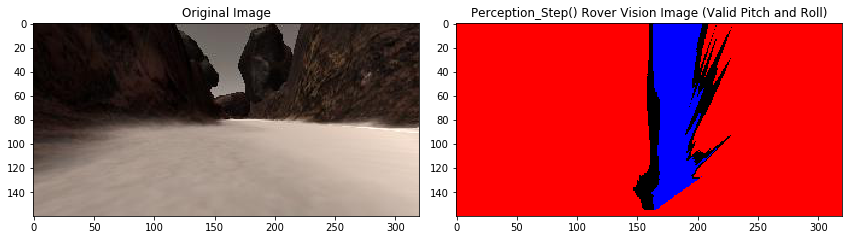

In [12]:
####### Valid pitch and roll #######
Rover.pitch = 0.0
Rover.roll = 0.0
Rover.img = image
perception.perception_step(Rover)
output_img = generate_overlay(Rover, image_source, image_destination)

fig = plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
plt.tight_layout()
plt.title("Original Image")
plt.imshow(Rover.img, cmap='gray')

plt.subplot(1,2,2)
plt.tight_layout()
plt.title("Perception_Step() Rover Vision Image (Valid Pitch and Roll)")
plt.imshow(Rover.vision_image, cmap='gray')

# Change the image. An invalid pitch and roll will cause the perception step image to match the last one
# A valid pitch and roll will update the perception step image.
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])

####### Invalid pitch and roll #######
Rover.pitch = 10.5
Rover.roll = 300.0
Rover.img = image
perception.perception_step(Rover)
output_img = generate_overlay(Rover, image_source, image_destination)

fig = plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
plt.tight_layout()
plt.title("Original Image")
plt.imshow(Rover.img, cmap='gray')

plt.subplot(1,2,2)
plt.tight_layout()
plt.title("Perception_Step() Rover Vision Image (Invalid Pitch and Roll)")
plt.imshow(Rover.vision_image, cmap='gray')

####### Valid pitch and roll #######
Rover.pitch = 359.9
Rover.roll = 0.2
Rover.img = image
perception.perception_step(Rover)
output_img = generate_overlay(Rover, image_source, image_destination)

fig = plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
plt.tight_layout()
plt.title("Original Image")
plt.imshow(Rover.img, cmap='gray')

plt.subplot(1,2,2)
plt.tight_layout()
plt.title("Perception_Step() Rover Vision Image (Valid Pitch and Roll)")
plt.imshow(Rover.vision_image, cmap='gray')

### Fix the analysis step conversion error

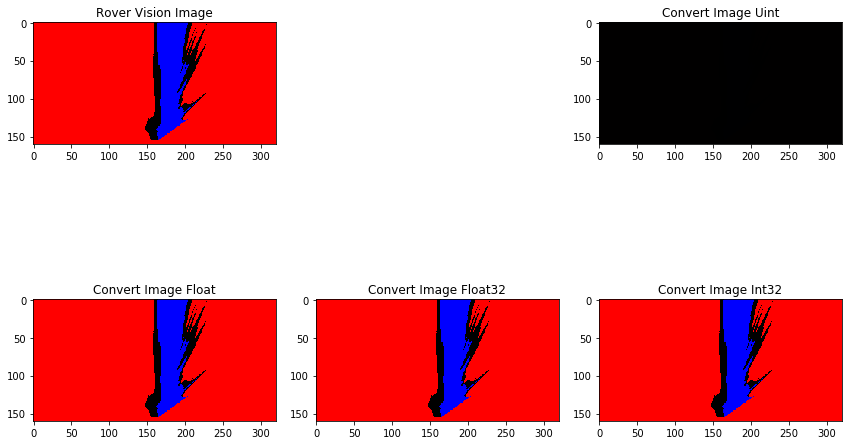

In [74]:
import perception
from io import BytesIO, StringIO
import base64

fig = plt.figure(figsize=(12,9))
plt.subplot(2,3,1)
plt.tight_layout()
plt.title("Rover Vision Image")
plt.imshow(Rover.vision_image, cmap='gray')

plt.subplot(2,3,2)
plt.tight_layout()
plt.title("Vision Image Upload")
pil_img = Image.fromarray(Rover.vision_image.astype(np.uint8))
plt.imshow(pil_img, cmap='gray')

plt.subplot(2,3,3)
plt.tight_layout()
plt.title("Convert Image Uint")
plt.imshow(Rover.vision_image.astype(np.uint8), cmap='gray')

plt.subplot(2,3,4)
plt.tight_layout()
plt.title("Convert Image Float")
plt.imshow(Rover.vision_image.astype(np.float), cmap='gray')

#using parameter astype(np.uint8, casting='safe') returned an error that float 64 can't be converted to uint8
plt.subplot(2,3,5)
plt.tight_layout()
plt.title("Convert Image Float32")
newdata = Rover.vision_image.astype(np.float32)
plt.imshow(newdata, cmap='gray')

plt.subplot(2,3,6)
plt.tight_layout()
plt.title("Convert Image Int32")
newdata = 255 * Rover.vision_image
newdata = newdata.astype(np.uint8)
plt.imshow(newdata, cmap='gray')


### Fine tuning color threshold

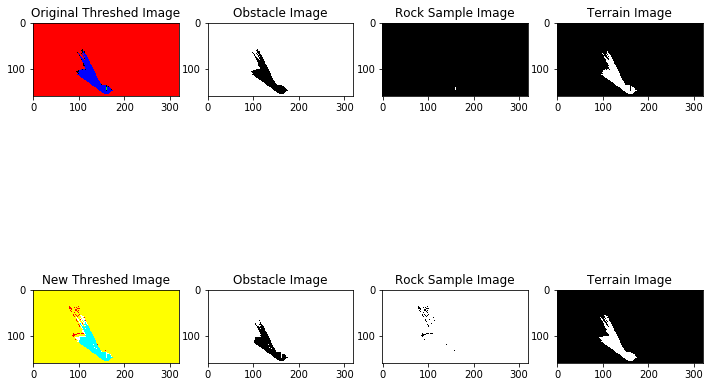

In [48]:
# Identify pixels above and below given thresholds
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh_old(img, rgb_thresh_lower=(160, 160, 160), rgb_thresh_upper=(255, 255, 255)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] >= rgb_thresh_lower[0]) \
                & (img[:,:,1] >= rgb_thresh_lower[1]) \
                & (img[:,:,2] >= rgb_thresh_lower[2])
    
    # Require that each pixel be below all three threshold values in RGB
    # below_thresh will now contain a boolean array with "True"
    # where threshold was met
    below_thresh = (img[:,:,0] <= rgb_thresh_upper[0]) \
                & (img[:,:,1] <= rgb_thresh_upper[1]) \
                & (img[:,:,2] <= rgb_thresh_upper[2])
            
    thresh = above_thresh & below_thresh
            
    # Index the array of zeros with the boolean array and set to 1
    color_select[thresh] = 1
    # Return the binary image
    return color_select

def color_thresh_new(img, rgb_thresh_lower=(160, 160, 160), rgb_thresh_upper=(255, 255, 255)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0], dtype=np.uint8)
    # Require that each pixel be within the threshold values in RGB
    # each array will now contain a boolean array with "True"
    # where thresholds were met
    for color in range(0,3):
        
        thresh = (img[:,:,color] >= rgb_thresh_lower[color]) & (img[:,:,color] <= rgb_thresh_upper[color])
        # Index the array of zeros with the boolean array and set to 1
        color_select[thresh] |= 1
        
    # Return the binary image
    return color_select

#Check that the threshold updates work
# 0 is obstacle data (Red)
# 1 is rock sample data (Green)
# 3 is navigatable terrain data (Blue)
color_max_thresh = [(160, 160, 160), (255, 255, 75), (255, 255, 255)]
color_min_thresh = [(0, 0, 0), (125, 100, 0), (160, 160, 160)]
thresh_image_old = np.zeros((160, 320, 3), dtype=np.float)
thresh_image_new = np.zeros((160, 320, 3), dtype=np.float)

example_rock = '../calibration_images/example_rock1.jpg'
image_rock = mpimg.imread(example_rock)

rover_dst_size = 5 
rover_bottom_offset = 6
image_rock_source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
image_rock_destination = np.float32([[image_rock.shape[1]/2 - rover_dst_size, image_rock.shape[0] - rover_bottom_offset],
              [image_rock.shape[1]/2 + rover_dst_size, image_rock.shape[0] - rover_bottom_offset],
              [image_rock.shape[1]/2 + rover_dst_size, image_rock.shape[0] - 2*rover_dst_size - rover_bottom_offset], 
              [image_rock.shape[1]/2 - rover_dst_size, image_rock.shape[0] - 2*rover_dst_size - rover_bottom_offset],
              ]) 
warped = perception.perspect_transform(image_rock, image_rock_source, image_rock_destination)

thresh_image_old[:,:,0] = color_thresh_old(warped, color_min_thresh[0], color_max_thresh[0])
thresh_image_old[:,:,1] = color_thresh_old(warped, color_min_thresh[1], color_max_thresh[1])
thresh_image_old[:,:,2] = color_thresh_old(warped, color_min_thresh[2], color_max_thresh[2])
fig = plt.figure(figsize=(12,9))
plt.subplot(241)
plt.title("Original Threshed Image")
plt.imshow(thresh_image_old, cmap='gray')

obstacle = color_thresh_old(warped, color_min_thresh[0], color_max_thresh[0])
plt.subplot(242)
plt.title("Obstacle Image")
plt.imshow(obstacle, cmap='gray')

sample = color_thresh_old(warped, color_min_thresh[1], color_max_thresh[1])
plt.subplot(243)
plt.title("Rock Sample Image")
plt.imshow(sample, cmap='gray')

terrain = color_thresh_old(warped, color_min_thresh[2], color_max_thresh[2])
plt.subplot(244)
plt.title("Terrain Image")
plt.imshow(terrain, cmap='gray')


thresh_image_new[:,:,0] = color_thresh_new(warped, color_min_thresh[0], color_max_thresh[0])
thresh_image_new[:,:,1] = color_thresh_new(warped, color_min_thresh[1], color_max_thresh[1])
thresh_image_new[:,:,2] = color_thresh_new(warped, color_min_thresh[2], color_max_thresh[2])
plt.subplot(245)
plt.title("New Threshed Image")
plt.imshow(thresh_image_new, cmap='gray')

obstacle = color_thresh_new(warped, color_min_thresh[0], color_max_thresh[0])
plt.subplot(246)
plt.title("Obstacle Image")
plt.imshow(obstacle, cmap='gray')

sample = color_thresh_new(warped, color_min_thresh[1], color_max_thresh[1])
plt.subplot(247)
plt.title("Rock Sample Image")
plt.imshow(sample, cmap='gray')

terrain = color_thresh_new(warped, color_min_thresh[2], color_max_thresh[2])
plt.subplot(248)
plt.title("Terrain Image")
plt.imshow(terrain, cmap='gray')